# 4th Tutorial - Convolutional Neural Networks in PyTorch

In this tutorial, we want to you to get familiar with the implementation of Convolutional Neural Networks in PyTorch and let you investigate how the single neural network layers contribute to the final result. Sections which are marked as <font color='#e52425'>Assignments</font> there you have to add something related to the tasks between the comments ### TODO Start ### and ### TODO End ###.

<strong>_recommended literature for Convolutional Neural Networks:_ </strong> <br>
* _Deep Learning (Ian Goodfellow and Yoshua Bengio and Aaron Courville)_ ( https://www.deeplearningbook.org/contents/convnets.html )<br>



In [1]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

<img src='cifar10.png' width="500" height="500">

Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [2]:
import os
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
import ssl
# fix for https://github.com/pytorch/pytorch/issues/33288
ssl._create_default_https_context = ssl._create_unverified_context

#### 1. Loading and normalizing CIFAR10
-----------

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [5]:
import os
import scipy
import numpy as np
import torchvision

The output of torchvision datasets are numpy images of range [0, 255].

In [6]:
dataset_root="./cifar_10/"
cifar10_data = torchvision.datasets.CIFAR10(root=f"{dataset_root}", download=True)
classes_uq = list(np.unique(cifar10_data.targets))
num_classes = len(classes_uq)
print(f"{num_classes} classes: {classes_uq}")
cifar10_data.data[0][0][:10]

10 classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


array([[ 59,  62,  63],
       [ 43,  46,  45],
       [ 50,  48,  43],
       [ 68,  54,  42],
       [ 98,  73,  52],
       [119,  91,  63],
       [139, 107,  75],
       [145, 110,  80],
       [149, 117,  89],
       [149, 120,  93]], dtype=uint8)

We transform them to Tensors of normalized range [-1, 1].
<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>

In [7]:
#num_workers = 0
num_workers = os.cpu_count()
bs=32

print(f"{num_workers} workers set for data_loader.")

transform = transforms.Compose(
    [
    transforms.ToTensor()  # ToTensor will scale PILImage pixels with values from [0,255] to tensor image with values from [0,1] 
    ,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize will first subtract the mean so [0,1] values will transform to range [-0.5,0.5], and then will divide with std and [-0.5,0.5] will reach [-1,1] range
    ])

# Use your own image instead of CIFAR10:
# trainset = datasets.ImageFolder(root=f"{dataset_root}/train", transform=transform)
trainset = torchvision.datasets.CIFAR10(root=f"{dataset_root}", train=True,
                                        download=True, transform=transform)
# DataLoader returns a iterator that returns a batch of images and labels for each iteration
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(root=f"{dataset_root}", train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


print(trainset[0]) # trainset[x] = (image, label), image is of shape [3, 32, 32]
# Check the image siza, min and max value
print(trainset[0][0].size(), trainset[0][0].min(), trainset[0][0].max())

16 workers set for data_loader.
(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0

In [8]:
print(len(trainloader))
print(len(testloader))

1563
313


In [9]:
print(f"dataset.shape: {trainset.data.shape}")
print(f"dataset.targets")
for tg in np.unique(trainset.targets):
    print(f"{tg} -> {classes[tg]}")

dataset.shape: (50000, 32, 32, 3)
dataset.targets
0 -> plane
1 -> car
2 -> bird
3 -> cat
4 -> deer
5 -> dog
6 -> frog
7 -> horse
8 -> ship
9 -> truck


Let us show some of the training images, for fun.



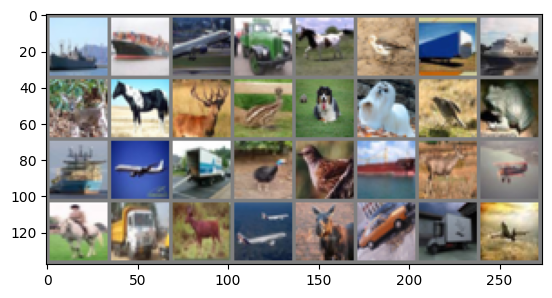

 ship  ship plane truck


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)  # Change from dataiter.next() to next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


#### 2. Define a Convolutional Neural Network
___
Create a CNN with the following architecture:<br>
<br>
Extracts 6 feature maps from the input image (h x w x c) using 5×5 filters:<br>
conv2d, in (input channel)=3, out (output channel)=6, kernel (nxn)=5<br>
ReLU<br>
maxpool2d, kernel=2<br>
<br>
conv2d, in=6, out=16, kernel=5<br>
ReLU<br>
maxpool2d, kernel=2<br>
<br>
flatten<br>
<br>
linear, in=16x5x5, out=120<br>
ReLU<br>
linear, in=120, out=84<br>
ReLu<br>
linear, in=84, out=number_of_possible_CIFAR10_classes<br>
<br>

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

#### 3. Define a Loss function and optimizer
____
Let's use a Classification Cross-Entropy loss and SGD with momentum 0.9 and a learning rate of 0.001.



In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### 4. Train the network
____

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [13]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()  # IMPORTANT: gradients accumulate by default in PyTorch

        # forward + backward + optimize
        outputs = net(inputs) # outputs contain reference to the computation graph that links back to net
        loss = criterion(outputs, labels)
        # loss.backward compute gradients with respect to each parameter and store it in hidden 
        # attribute .grad in each tensor (node) in the net
        loss.backward()
        optimizer.step()  # look at net, reads its .grad and update the parameter

        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 2.303
[1,   400] loss: 2.301
[1,   600] loss: 2.300
[1,   800] loss: 2.296
[1,  1000] loss: 2.286
[1,  1200] loss: 2.255
[1,  1400] loss: 2.146
[2,   200] loss: 2.000
[2,   400] loss: 1.959
[2,   600] loss: 1.914
[2,   800] loss: 1.885
[2,  1000] loss: 1.840
[2,  1200] loss: 1.805
[2,  1400] loss: 1.771
Finished Training


Let's quickly save our trained model:

In [14]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
!dir | grep pth

cifar_10  cifar_net.pth  week-4-convolutional-neural-networks.ipynb


See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
for more details on saving PyTorch models.

#### 5. Test the network on the test data
_____

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



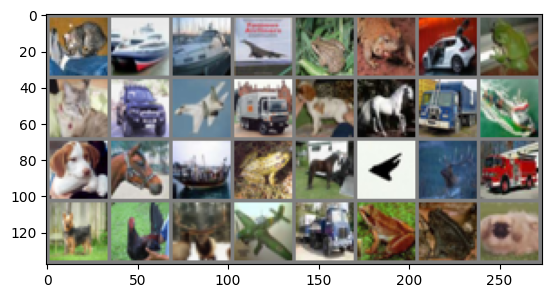

GroundTruth:    cat  ship  ship plane


In [15]:
import torchvision

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [16]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [17]:
outputs = net(images)
print(f"outputs.shape: {outputs.shape}") # 32 image with 10 class prediction each

num_samples=4
outputs[:num_samples] # check the first 4 rows 

outputs.shape: torch.Size([32, 10])


tensor([[-0.5417,  0.3443,  0.2162,  1.7234, -0.4518,  1.2587,  0.7372, -1.3161,
         -0.0583, -0.5248],
        [ 2.4920,  4.0509, -0.9921, -2.1857, -2.0140, -2.0200, -4.5969, -2.0430,
          4.4094,  2.6881],
        [ 1.5830,  2.3663, -0.5904, -0.9260, -1.6862, -0.7609, -3.1967, -1.3570,
          2.9395,  1.4999],
        [ 2.8665,  1.4945,  0.6422, -1.2007, -0.8134, -1.2252, -3.5597, -1.6169,
          2.7852,  0.5646]], grad_fn=<SliceBackward0>)

The outputs are energies for the 10 classes of 4 images. Since energies give no sense about the confidence for a class, lets transform the energies into proabilites by applying the Softmax function:

In [18]:
def get_outputs_proba(ooutputs):
    # apply software across the class dimension. dimension 0 is row, 1 is columns
    softmax = nn.Softmax(dim=1)
    outputs_proba = softmax(ooutputs)
    return outputs_proba

outputs_proba = get_outputs_proba(outputs[:num_samples])
outputs_proba

tensor([[3.4449e-02, 8.3547e-02, 7.3505e-02, 3.3181e-01, 3.7688e-02, 2.0848e-01,
         1.2375e-01, 1.5879e-02, 5.5860e-02, 3.5035e-02],
        [7.2217e-02, 3.4331e-01, 2.2157e-03, 6.7164e-04, 7.9749e-04, 7.9267e-04,
         6.0250e-05, 7.7464e-04, 4.9130e-01, 8.7863e-02],
        [1.1930e-01, 2.6113e-01, 1.3576e-02, 9.7048e-03, 4.5381e-03, 1.1447e-02,
         1.0020e-03, 6.3074e-03, 4.6320e-01, 1.0980e-01],
        [4.0721e-01, 1.0327e-01, 4.4038e-02, 6.9735e-03, 1.0272e-02, 6.8046e-03,
         6.5913e-04, 4.5993e-03, 3.7543e-01, 4.0748e-02]],
       grad_fn=<SoftmaxBackward0>)

The higher the confidence (probability) for a class, the more the network thinks that the image is of the particular class.
<br>So, let's sort the outputs by confidence:

In [19]:
def get_outputs_proba_sorted(ooutputs_proba_):
    return torch.sort(ooutputs_proba_.detach(), dim=1, descending=True)

outputs_proba_sorted = get_outputs_proba_sorted(outputs_proba[:num_samples])
outputs_proba_sorted

torch.return_types.sort(
values=tensor([[3.3181e-01, 2.0848e-01, 1.2375e-01, 8.3547e-02, 7.3505e-02, 5.5860e-02,
         3.7688e-02, 3.5035e-02, 3.4449e-02, 1.5879e-02],
        [4.9130e-01, 3.4331e-01, 8.7863e-02, 7.2217e-02, 2.2157e-03, 7.9749e-04,
         7.9267e-04, 7.7464e-04, 6.7164e-04, 6.0250e-05],
        [4.6320e-01, 2.6113e-01, 1.1930e-01, 1.0980e-01, 1.3576e-02, 1.1447e-02,
         9.7048e-03, 6.3074e-03, 4.5381e-03, 1.0020e-03],
        [4.0721e-01, 3.7543e-01, 1.0327e-01, 4.4038e-02, 4.0748e-02, 1.0272e-02,
         6.9735e-03, 6.8046e-03, 4.5993e-03, 6.5913e-04]]),
indices=tensor([[3, 5, 6, 1, 2, 8, 4, 9, 0, 7],
        [8, 1, 9, 0, 2, 4, 5, 7, 3, 6],
        [8, 1, 0, 9, 2, 5, 3, 7, 4, 6],
        [0, 8, 1, 2, 9, 4, 3, 5, 7, 6]]))

Store the confidence per image in a list together with its predicted class label and ground truth class label!

In [20]:
def get_predictions(outputs_, labels_, classes, highest_only=False):
    preds=[]
    
    outputs_proba_ = get_outputs_proba(outputs_)    
    outputs_proba_sorted_ = get_outputs_proba_sorted(outputs_proba_)
    
    for sample_idx in range(0, len(outputs_proba_sorted_.values)): # loop from 0 to batch_size-1
        pred = []
        for idx in range(0, len(outputs_proba_sorted_.indices[sample_idx, :])):
            pred_val = outputs_proba_sorted_.values[sample_idx, idx]
            pred_cls = outputs_proba_sorted_.indices[sample_idx, idx] 
            gt_class = classes[labels_[sample_idx]]
            pred_class = classes[pred_cls]
            pred_conf = round(pred_val.item(),5)
            pred.append(f"image{sample_idx} - gt:{gt_class}|pred:{pred_class} ({pred_conf})")
            if highest_only: break
        preds.append(pred)
    return preds

num_samples=4
get_predictions(outputs[:num_samples], labels[:num_samples], classes, highest_only=False)

[['image0 - gt:cat|pred:cat (0.33181)',
  'image0 - gt:cat|pred:dog (0.20848)',
  'image0 - gt:cat|pred:frog (0.12375)',
  'image0 - gt:cat|pred:car (0.08355)',
  'image0 - gt:cat|pred:bird (0.0735)',
  'image0 - gt:cat|pred:ship (0.05586)',
  'image0 - gt:cat|pred:deer (0.03769)',
  'image0 - gt:cat|pred:truck (0.03504)',
  'image0 - gt:cat|pred:plane (0.03445)',
  'image0 - gt:cat|pred:horse (0.01588)'],
 ['image1 - gt:ship|pred:ship (0.4913)',
  'image1 - gt:ship|pred:car (0.34331)',
  'image1 - gt:ship|pred:truck (0.08786)',
  'image1 - gt:ship|pred:plane (0.07222)',
  'image1 - gt:ship|pred:bird (0.00222)',
  'image1 - gt:ship|pred:deer (0.0008)',
  'image1 - gt:ship|pred:dog (0.00079)',
  'image1 - gt:ship|pred:horse (0.00077)',
  'image1 - gt:ship|pred:cat (0.00067)',
  'image1 - gt:ship|pred:frog (6e-05)'],
 ['image2 - gt:ship|pred:ship (0.4632)',
  'image2 - gt:ship|pred:car (0.26113)',
  'image2 - gt:ship|pred:plane (0.1193)',
  'image2 - gt:ship|pred:truck (0.1098)',
  'imag

In [21]:
get_predictions(outputs[:num_samples], labels[:num_samples], classes, highest_only=True)

[['image0 - gt:cat|pred:cat (0.33181)'],
 ['image1 - gt:ship|pred:ship (0.4913)'],
 ['image2 - gt:ship|pred:ship (0.4632)'],
 ['image3 - gt:plane|pred:plane (0.40721)']]

As one can observe, the CNN has even for the highest confidence not actually a high confidence.<br>Nevertheless, filter for each image the output with the highest confidence and plot the related predicted class label together with the ground truth label and image:

  Predicted:    cat  ship  ship plane
GroundTruth:    cat  ship  ship plane


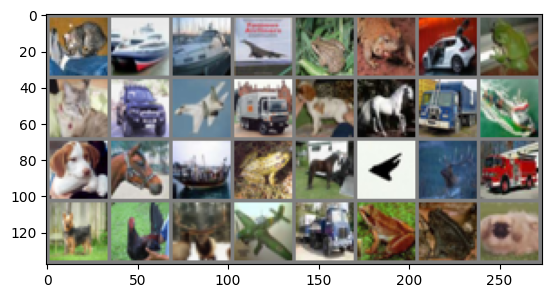

In [22]:
# outputs [32, 10], 1 means find the max along dimension 1
_, predicted = torch.max(outputs, 1)

print('  Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(num_samples)))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(num_samples)))
imshow(torchvision.utils.make_grid(images))

Let us look at how the network performs on the whole dataset by creating a classification report with sklearn.

In [23]:
from sklearn.metrics import classification_report

def evaluate_performance(test_model, testloader, classes):
    correct = 0
    total = 0
    predictions=[]
    groundtruth=[]
    device = "cuda" if torch.cuda.is_available() else "cpu"
    test_model = test_model.to(device)
    test_model.eval()
    with torch.no_grad(): # Saves memory and computation since gradients aren’t needed during evaluation
        for data in testloader:
            x_batch, y_batch = data[0].to(device), data[1].to(device)
            outputs = test_model(x_batch.to(device))
            _, predicted = torch.max(outputs.data, 1)
            # PyTorch use CPU memory by default but can move tensors/models to cuda
            # scikit-learn built on NumPy arrays, which only understands CPU memory
            # => do heavylifting with Pytorch and do data generation with CPU
            predictions.extend(predicted.cpu())
            groundtruth.extend(y_batch.cpu())
    print(classification_report(y_true=groundtruth, y_pred=predictions, target_names=classes))
    
evaluate_performance(net, testloader, classes)

              precision    recall  f1-score   support

       plane       0.46      0.51      0.48      1000
         car       0.40      0.63      0.49      1000
        bird       0.30      0.14      0.19      1000
         cat       0.30      0.22      0.25      1000
        deer       0.35      0.20      0.26      1000
         dog       0.34      0.39      0.36      1000
        frog       0.36      0.64      0.46      1000
       horse       0.42      0.48      0.45      1000
        ship       0.43      0.39      0.41      1000
       truck       0.46      0.25      0.32      1000

    accuracy                           0.39     10000
   macro avg       0.38      0.39      0.37     10000
weighted avg       0.38      0.39      0.37     10000



Accuracy of the network on the 10000 test images: ~40 %
That looks better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learned something.

Ok, lets try to improve the performance by using ResNet18. Since it has much more weights to train compared to our simple CNN we need to speed up the training process by utilizing a GPU. But how do we run train neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

### Reference of time consumption between GPU and CPU
#### GPU
- Current time: 18:05:17
- Time: 18:05:28 Epoch 1/6 b1000 - train
- Time: 18:05:36 Epoch 1/6 trn/tst: 0.053693468470939136/0.043011033586181774
- Time: 18:05:45 Epoch 2/6 b1000 - train
- Time: 18:05:53 Epoch 2/6 trn/tst: 0.03673736182931079/0.03530504808615381
- Time: 18:06:03 Epoch 3/6 b1000 - train
- Time: 18:06:09 Epoch 3/6 trn/tst: 0.02864667123585215/0.028543601306482626
- Time: 18:06:20 Epoch 4/6 b1000 - train
- Time: 18:06:28 Epoch 4/6 trn/tst: 0.024033958201373492/0.024221033450013724
- Time: 18:06:39 Epoch 5/6 b1000 - train
- Time: 18:06:45 Epoch 5/6 trn/tst: 0.02045257972500937/0.021295299395002402
- Time: 18:06:56 Epoch 6/6 b1000 - train
- Time: 18:07:03 Epoch 6/6 trn/tst: 0.017685358471553524/0.02172114691152549

#### CPU
- Time: 18:14:40 Epoch 1/6 b1000 - train
- Time: 18:15:12 Epoch 1/6 trn/tst: 0.054711542539751384/0.05508317545461007
- Time: 18:16:02 Epoch 2/6 b1000 - train
- Time: 18:16:32 Epoch 2/6 trn/tst: 0.037130145300048635/0.03071123092604902
- Time: 18:17:19 Epoch 3/6 b1000 - train
- Time: 18:17:50 Epoch 3/6 trn/tst: 0.030468353517806385/0.02712642900443401
- Time: 18:18:36 Epoch 4/6 b1000 - train
- Time: 18:19:06 Epoch 4/6 trn/tst: 0.025452217608523422/0.02464024367007299
- Time: 18:19:58 Epoch 5/6 b1000 - train
- Time: 18:20:27 Epoch 5/6 trn/tst: 0.022758174033374337/0.02856191648795201
- Time: 18:21:14 Epoch 6/6 b1000 - train
- Time: 18:21:43 Epoch 6/6 trn/tst: 0.01878413046404519/0.02577940307962247

Let's first define our device as the first visible cuda device if we have
CUDA available:

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


Did you receive a response with device "cuda" or "cuda:0"?

If yes, then the rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    model.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        x_batch, y_batch = data[0].to(device), data[1].to(device)

In [25]:
print(f"{num_classes} classes:")
print(classes_uq)

10 classes:
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


Current time: 18:26:58


/mnt/c/Users/jjack/Repos/deep-learning-practice/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/c/Users/jjack/Repos/deep-learning-practice/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Time: 18:27:07 Epoch 1/6 b1000 - train
Time: 18:27:16 Epoch 1/6 trn/tst: 0.05149388371806494/0.04506155359335601
Time: 18:27:28 Epoch 2/6 b1000 - train
Time: 18:27:36 Epoch 2/6 trn/tst: 0.034952355725708595/0.029588394878676143
Time: 18:27:46 Epoch 3/6 b1000 - train
Time: 18:27:53 Epoch 3/6 trn/tst: 0.0286508419795852/0.029843017786217573
Time: 18:28:05 Epoch 4/6 b1000 - train
Time: 18:28:11 Epoch 4/6 trn/tst: 0.024073746186452877/0.02455971952373037
Time: 18:28:22 Epoch 5/6 b1000 - train
Time: 18:28:29 Epoch 5/6 trn/tst: 0.023261606876493472/0.027018892528197634
Time: 18:28:40 Epoch 6/6 b1000 - train
Time: 18:28:46 Epoch 6/6 trn/tst: 0.019018272117021007/0.022396516405974332


<Axes: xlabel='Epoch'>

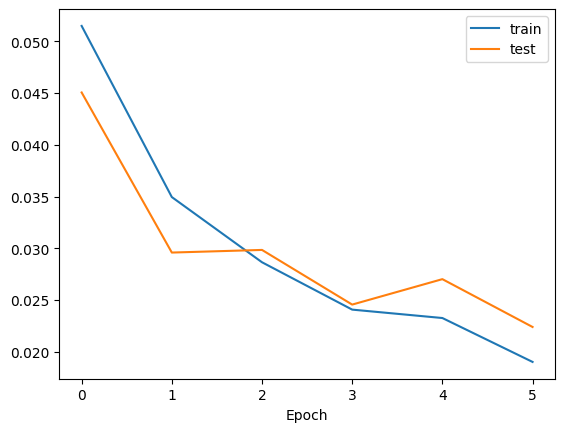

In [26]:
import torchvision.models as models
import pandas as pd
from datetime import datetime

# Load the model with weights already trained on ImageNet
model = models.resnet18(pretrained=True)

# since resnet18 ends up with a final linear layer (model.fc) of size 1000 we need to adapt it to our number of total classes before we train it
# replace the final layer from in_feature 512 out_feature 1000 to in_feature 512 out_feature num_classes 
model.fc = nn.Linear(512, num_classes)

# assign model to device (GPU or CPU)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 6

# print current time to compare the training time with CPU and GPU
print("Current time:", datetime.now().strftime("%H:%M:%S"))

# train
trn_losses=[]
tst_losses=[]
for epoch in range(epochs):
    # set the model to training mode
    # training has dropout (randomly zeros outactivations) during forward pass to prevent 
    # the network form relying too heavily on specific neurons
    # training use BatchNorm to normalize the current batch's mean/variance while 
    # evaluation use running average since it doesn't have the access to batch data
    model.train()
    bidx=0
    batch_losses=[]
    for data in trainloader:
        bidx+=1
        
        optimizer.zero_grad() # clear old gradients before the next iteration
        # both model and training data (inputs, labels) should be transfer to cuda memory
        x_batch, y_batch = data[0].to(device), data[1].to(device)
        
        y_batch_preds = model(x_batch)
        loss = criterion(input=y_batch_preds, target=y_batch)
        loss.backward()
        # calculate the loss.item(float)/batch_size
        # .item converts a 0-dim tensor (i.e. scalar tensor) (may be in GPU or CPU) to a plain Python float
        # .shape is just a Python integer representing the batch size
        # Both Python float and integer always live in CPU
        batch_loss = loss.item()/x_batch.shape[0]
        batch_losses.append(batch_loss)
        
        optimizer.step() # update parameters
        if bidx % 1000 == 0:
            print('Time: {} Epoch {}/{} b{} - train'.format(datetime.now().strftime("%H:%M:%S"), epoch + 1, epochs, bidx))
            
    trn_losses.append(np.array(batch_losses).mean())

    # set the model to evaluate mode
    model.eval()
    with torch.no_grad(): # temprarily disables gradient tracking to avoid overhead on graph construction
        bidx=0
        batch_losses=[]
        for data in testloader:
            bidx+=1   
            x_batch, y_batch = data[0].to(device), data[1].to(device)
            
            y_batch_preds = model(x_batch)
            loss = criterion(input=y_batch_preds, target=y_batch)
            
            batch_loss = loss.item()/x_batch.shape[0]
            batch_losses.append(batch_loss)
            
            if bidx % 1000 == 0:
                print('Time: {} Epoch {}/{} b{} - test'.format(datetime.now().strftime("%H:%M:%S"), epoch + 1, epochs, bidx)) 
                
        tst_losses.append(np.array(batch_losses).mean())
            
    print('Time: {} Epoch {}/{} trn/tst: {}/{}'.format(datetime.now().strftime("%H:%M:%S"), epoch + 1, epochs, trn_losses[-1], tst_losses[-1])) 

# Pandas is built on NumPy, which is CPU-based. The input should be stored in CPU not GPU
df=pd.DataFrame({'Epoch': [e for e in range(epoch + 1)], 'train': trn_losses, 'test': tst_losses})
df.plot(x=0, xticks=df.index.tolist())

  Predicted:    cat   car  ship plane
GroundTruth:    cat  ship  ship plane


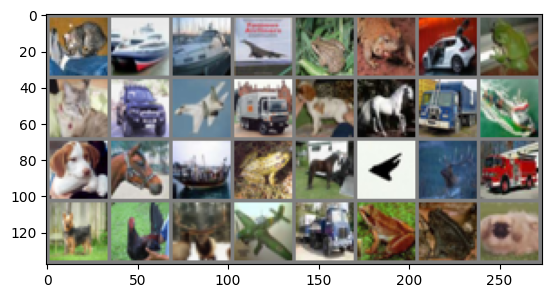

In [27]:
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

print('  Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(images))

In [28]:
num_samples=4
get_predictions(outputs[:num_samples], labels[:num_samples], classes, highest_only=False)

[['image0 - gt:cat|pred:cat (0.85579)',
  'image0 - gt:cat|pred:frog (0.10375)',
  'image0 - gt:cat|pred:dog (0.03358)',
  'image0 - gt:cat|pred:bird (0.00352)',
  'image0 - gt:cat|pred:deer (0.00177)',
  'image0 - gt:cat|pred:horse (0.00063)',
  'image0 - gt:cat|pred:plane (0.00046)',
  'image0 - gt:cat|pred:ship (0.00038)',
  'image0 - gt:cat|pred:truck (8e-05)',
  'image0 - gt:cat|pred:car (5e-05)'],
 ['image1 - gt:ship|pred:car (0.74073)',
  'image1 - gt:ship|pred:ship (0.24988)',
  'image1 - gt:ship|pred:truck (0.00732)',
  'image1 - gt:ship|pred:plane (0.0018)',
  'image1 - gt:ship|pred:cat (7e-05)',
  'image1 - gt:ship|pred:frog (6e-05)',
  'image1 - gt:ship|pred:deer (6e-05)',
  'image1 - gt:ship|pred:dog (4e-05)',
  'image1 - gt:ship|pred:bird (3e-05)',
  'image1 - gt:ship|pred:horse (0.0)'],
 ['image2 - gt:ship|pred:ship (0.81282)',
  'image2 - gt:ship|pred:plane (0.15967)',
  'image2 - gt:ship|pred:bird (0.00877)',
  'image2 - gt:ship|pred:cat (0.00646)',
  'image2 - gt:ship

In [29]:
get_predictions(outputs[:num_samples], labels[:num_samples], classes, highest_only=True)

[['image0 - gt:cat|pred:cat (0.85579)'],
 ['image1 - gt:ship|pred:car (0.74073)'],
 ['image2 - gt:ship|pred:ship (0.81282)'],
 ['image3 - gt:plane|pred:plane (0.69922)']]

Now we observe that the confidences for the highest class are much more certain compared to those of the first small model.<br>Lets also evaluate the overall performance:

In [30]:
evaluate_performance(model, testloader, classes)

              precision    recall  f1-score   support

       plane       0.81      0.76      0.78      1000
         car       0.85      0.85      0.85      1000
        bird       0.73      0.68      0.70      1000
         cat       0.63      0.57      0.60      1000
        deer       0.71      0.78      0.74      1000
         dog       0.66      0.67      0.67      1000
        frog       0.75      0.87      0.81      1000
       horse       0.81      0.82      0.81      1000
        ship       0.79      0.87      0.83      1000
       truck       0.90      0.77      0.83      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



So as you see, using a pretrained resnet18 improves the network performance significantly but there is still space for improvement.

Why dont I notice MASSIVE speedup compared to CPU? Because your network is really small.<br>


**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.




**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images
- Train on CPU and GPU
